In [2]:
import pandas as pd
import numpy as np
import scanpy as sc

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from matplotlib import colors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
adata = sc.read_h5ad('scRNAseq_pancan_MALE_after_SCVI.h5ad')
adata

AnnData object with n_obs × n_vars = 497055 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'Celltype2', 'Celltype3', 'Cancertype_TCGA', 'RL_Prediction_Only9genes', 'LOY', 'obs_names', 'Celltype2_2'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'Celltype2_colors', 'DataID_colors', 'Organ_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

# LOY ratio

In [4]:
def get_LOY_fraction_plot(adata,ctlevel,Fig): 
    from scipy.stats import chi2_contingency

    #get count table
    data = pd.DataFrame(index = adata.obs[ctlevel].unique(), 
                        columns = ['WTY_SCR','LOY_SCR'])
    for loy in data.columns:
        data[loy]=pd.DataFrame(adata.obs.loc[adata.obs['LOY']==loy,ctlevel].value_counts()).iloc[:,0]     
    
    #get fraction table
    row_sum = data.sum(axis=1)
    data2 = data.div(row_sum,axis='rows')
    data2 = data2*100
    #sort 
    data2.sort_values('LOY_SCR',inplace=True)

    #Chi-square: sub_celltype vs other
    pvals = pd.DataFrame(index = data.index,columns=['pval'])
    for i in data.index:
        sub_data = pd.DataFrame(index = [i],columns = data.columns)
        sub_data.loc[i,:] = data.loc[i,:].copy()
        other = pd.DataFrame(data.sum()).T - data.loc[i,:].copy()
        
        other.index = ['other']
        sub_data = pd.concat([sub_data, other])

        stat, pval, dof, expected = chi2_contingency(sub_data)
        pvals.loc[i,'pval'] = pval
    
    #plot
    fig, ax = plt.subplots(figsize=(2,1.5))
    data2.plot(kind='bar', stacked=True, color=['#195697','#c11c1d'],edgecolor='White',linewidth=1,ax=ax,width=0.9)
    labels = ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    labels = ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    plt.legend(loc = (1,0.5), fontsize = 7, frameon=False)
    pvals = pvals.loc[data2.index,:].copy()
    for x in range(0,pvals.shape[0]):
        if pvals.iloc[x,0]<0.05:
            plt.text( x=x, y=110, fontsize=8,s='*')
    plt.savefig(f'figures/{Fig}_LOY_percentage.pdf',bbox_inches='tight',dpi=300,transparent=True)
    

/tmp/ipykernel_331572/3089470704.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  labels = ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


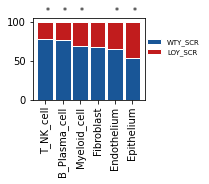

In [5]:
#Fig4a human
get_LOY_fraction_plot(adata=adata, ctlevel='Celltype1',Fig='Fig5A')

# LOY correlation

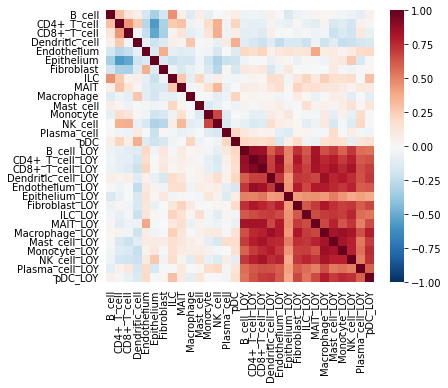

In [66]:
#Calculate LOY proportion for each cell type in each sample
data_LOY = adata.obs.groupby(['DataSampleID','Celltype2','LOY']).size().reset_index(name='count')
data_LOY = data_LOY.pivot_table(index=['DataSampleID','Celltype2'],columns='LOY',
                                values='count', fill_value=0)
row_sum = data_LOY.sum(axis=1)
data_LOY = data_LOY.div(row_sum,axis='rows')
data_LOY = pd.DataFrame(data_LOY.loc[:,'LOY_SCR'])
data_LOY = data_LOY.pivot_table(index='DataSampleID',columns='Celltype2',
                                values='LOY_SCR')
data_LOY.columns = [col+'_LOY' for col in data_LOY.columns]

#Calculate cell type proportion for each cell type in each sample
data_celltype = adata.obs.groupby(['DataSampleID','Celltype2']).size().reset_index(name='count')
data_celltype = data_celltype.pivot_table(index='DataSampleID',columns='Celltype2',
                                values='count', fill_value=0)
row_sum = data_celltype.sum(axis=1)
data_celltype = data_celltype.div(row_sum,axis='rows')

data = pd.concat([data_celltype,data_LOY],axis=1)
corr = data.corr()

#Fig5b
fig, ax = plt.subplots(figsize=(6,5))
plt.tick_params(left=False, bottom=False)
norm = colors.Normalize(vmin=-1,vmax=1)
sns.heatmap(corr, cmap = 'RdBu_r',norm=norm,yticklabels=1,xticklabels=1)
plt.savefig(f'figures/Fig5b_LOY_celltype_corr.pdf',bbox_inches='tight',dpi=300,transparent=True)

# Differential Expression Analaysis

In [5]:
adata = adata[adata.obs['Celltype2']!='Epithelium',:].copy()
adata

AnnData object with n_obs × n_vars = 340026 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'Celltype2', 'Celltype3', 'Cancertype_TCGA', 'RL_Prediction_Only9genes', 'LOY'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'DataID_colors', 'Organ_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
Celltypes = adata.obs['Celltype2'].unique()
adata.obs['Celltype2_LOY'] = adata.obs['Celltype2'].astype('str')+'_'+adata.obs['LOY'].astype('str')

In [74]:
res = pd.DataFrame()
for celltype in Celltypes:
    sc.tl.rank_genes_groups(adata, 'Celltype2_LOY', groups=[f'{celltype}_LOY_SCR'],
                           use_raw=False, reference=f'{celltype}_WTY_SCR', method='wilcoxon')
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    sub_res = pd.DataFrame({group + '_' + key: result[key][group]  for group in groups for key in ['names','logfoldchanges','pvals','pvals_adj','scores']})
    res = pd.concat([res,sub_res],axis=1)
res.to_csv('ExtendedData_Table9_DGE.csv')
res

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, p

,Endothelium_LOY_SCR_names,Endothelium_LOY_SCR_logfoldchanges,Endothelium_LOY_SCR_pvals,Endothelium_LOY_SCR_pvals_adj,Endothelium_LOY_SCR_scores,Fibroblast_LOY_SCR_names,Fibroblast_LOY_SCR_logfoldchanges,Fibroblast_LOY_SCR_pvals,Fibroblast_LOY_SCR_pvals_adj,Fibroblast_LOY_SCR_scores,...,MAIT_LOY_SCR_names,MAIT_LOY_SCR_logfoldchanges,MAIT_LOY_SCR_pvals,MAIT_LOY_SCR_pvals_adj,MAIT_LOY_SCR_scores,Monocyte_LOY_SCR_names,Monocyte_LOY_SCR_logfoldchanges,Monocyte_LOY_SCR_pvals,Monocyte_LOY_SCR_pvals_adj,Monocyte_LOY_SCR_scores
0,XIST,10.006480,0.000000e+00,0.000000e+00,64.165421,XIST,7.987121,0.000000e+00,0.000000e+00,37.996922,...,RPL41,1.123600,3.731617e-154,2.628924e-150,26.449152,MALAT1,0.461685,1.015523e-104,7.530902e-102,21.732315
1,S100A2,3.722147,1.961521e-257,3.454728e-254,34.273304,HSPB1,0.385739,2.302970e-145,3.244884e-142,25.673639,...,RPL31,1.327024,5.575283e-119,2.618525e-115,23.191286,NEAT1,0.486352,5.161562e-104,3.463163e-101,21.657532
2,MALAT1,0.412729,1.501281e-236,1.923005e-233,32.841599,MALAT1,0.183108,1.346247e-90,7.587447e-88,20.184261,...,RPS4X,0.634212,7.770441e-116,2.737138e-112,22.877573,RPL41,0.389036,8.446235e-95,4.577210e-92,20.656994
3,HSPB1,0.557924,6.478197e-205,4.804095e-202,30.545553,S100A2,2.528438,2.037943e-89,1.104408e-86,20.049522,...,RPS29,0.804763,2.793711e-111,7.872678e-108,22.415266,NAMPT,0.573663,3.043359e-72,8.090742e-70,17.975277
4,KRT17,2.380481,4.405345e-204,3.103566e-201,30.482800,HSPA1A,0.679361,4.475125e-87,2.174293e-84,19.779453,...,RPL36A,1.209311,3.539451e-90,7.124410e-87,20.136431,MT-ND2,0.289776,4.222861e-70,1.043862e-67,17.699602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14085,CD99,-0.976461,1.271776e-298,2.986555e-295,-36.934921,EEF1A1,-0.331527,2.210048e-215,5.189929e-212,-31.323843,...,MT-ND5,-1.482532,1.771278e-78,2.268846e-75,-18.754726,MT-ATP8,-1.691407,1.162461e-167,3.275814e-164,-27.598417
14086,VIM,-0.765372,2.644985e-299,7.453568e-296,-36.977383,EIF1AY,-9.789596,1.793058e-275,5.052839e-272,-35.463554,...,MT-CO2,-0.789815,6.221653e-83,8.766309e-80,-19.292400,DDX3Y,-12.728636,3.398499e-190,1.197121e-186,-29.416300
14087,ALDOA,-1.745948,0.000000e+00,0.000000e+00,-42.461365,CD99,-0.908132,0.000000e+00,0.000000e+00,-39.237316,...,MT-CO3,-0.928753,8.322531e-87,1.302938e-83,-19.748140,ALDOA,-1.506888,1.354131e-190,6.359903e-187,-29.447529
14088,DDX3Y,-10.271074,0.000000e+00,0.000000e+00,-46.772465,DDX3Y,-9.164840,0.000000e+00,0.000000e+00,-41.968616,...,MT-ATP6,-1.322923,3.336710e-98,7.835707e-95,-21.032084,EEF1A1,-0.686648,2.009947e-209,1.416008e-205,-30.883171


# CD4

In [76]:
CD4 = adata[adata.obs['Celltype2']=='CD4+_T_cell',:].copy()
CD4

AnnData object with n_obs × n_vars = 62008 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'Celltype2', 'Celltype3', 'Cancertype_TCGA', 'RL_Prediction_Only9genes', 'LOY', 'Celltype2_LOY_Level', 'Celltype2_LOY'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'Celltype2_colors', 'DataID_colors', 'Organ_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

### Pathway scores calculation

In [79]:
df_CD4 = pd.read_excel('Pathway_genelist_CD4.xlsx')
for column in df_CD4.columns:
    #Get gene list
    marker_Genes = df_CD4[column].dropna().tolist()  
    marker_Genes = set(marker_Genes).intersection(CD4.var_names)
    #Signature calculation
    sc.tl.score_genes(
        CD4,
        marker_Genes,
        ctrl_size=50,
        gene_pool=None,
        n_bins=25,
        score_name=column,  
        random_state=0,
        copy=False,
        use_raw=False
    )
CD4.write_h5ad('scRNAseq_pancan_Male_CD4.h5ad',compression='gzip')

In [4]:
CD4 = sc.read_h5ad('scRNAseq_pancan_Male_CD4.h5ad')

### Fig6b Gene Expr

In [84]:
genelist = ['TOX','ITGB2','TIGIT','PDCD1','CTLA4','TNFRSF4','LAG3','TNFRSF9','ICOS','BTLA','HAVCR2','IL2RA']

In [85]:
CD4.layers['scaled'] = sc.pp.scale(CD4,copy=True).X

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored

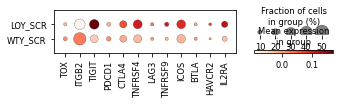

In [86]:
#Fig6b dotplot
sc.pl.dotplot(CD4, genelist, 'LOY', layer='scaled',dendrogram=False,
              figsize = (5,0.8),save='Fig6b_CD4_LOYvsnoLOY_gene_expr_IC_dot.pdf')

In [175]:
def get_bar(adata, genelist, n,m,ydn,yup,ysep,file):
    #DGE
    adata = adata[:,genelist].copy()
    sc.tl.rank_genes_groups(adata, 'LOY', groups=['LOY_SCR'],
                            use_raw=False, reference='WTY_SCR', method='wilcoxon')
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    data = pd.DataFrame({key: result[key][group]  for group in groups for key in ['names','logfoldchanges','pvals','pvals_adj']})
    data.index = data['names']
    #Calculate logP
    import math
    data['logpadj'] = [-math.log(max(i,1e-10),10) for i in data[f'pvals_adj']]
    #Reorder as dotplot
    data = data.loc[genes,:].copy()
    print(data)
    #Plotting
    from matplotlib import cm
    fig, axs = plt.subplots(1,2,figsize=(n,m),width_ratios=(60,1))#
    ax = axs[0]
    norm = mpl.colors.Normalize(vmin=0,vmax=10)
    mapper = cm.ScalarMappable(norm=norm,cmap=cm.Blues)
    colors = [mapper.to_rgba(i) for i in data['logpadj']]
    sns.barplot(x=data.index, y=data['logfoldchanges'],width=0.6,saturation=1,
                palette=colors,ax=ax)
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(ylim=(ydn,yup))
    y_majorocator=MultipleLocator(ysep)
    ax.yaxis.set_major_locator(y_majorocator)

    #Color bar
    ax = axs[1]
    mpl.colorbar.ColorbarBase(ax, cmap=cm.Blues,norm=norm)
    plt.savefig(file,dpi=300)


           names  logfoldchanges         pvals     pvals_adj    logpadj
names                                                                  
TOX          TOX       -0.198487  6.559709e-03  9.839563e-03   2.007024
ITGB2      ITGB2       -0.314915  1.576797e-30  9.460783e-30  10.000000
TIGIT      TIGIT        0.672102  8.897947e-49  1.067754e-47  10.000000
PDCD1      PDCD1       -0.136635  8.102671e-03  1.080356e-02   1.966433
CTLA4      CTLA4        0.266181  3.354156e-04  5.749981e-04   3.240334
TNFRSF4  TNFRSF4        0.423919  1.557472e-12  4.672415e-12  10.000000
LAG3        LAG3        0.193454  5.781460e-01  5.781460e-01   0.237963
TNFRSF9  TNFRSF9        0.637471  3.502172e-07  8.405212e-07   6.075451
ICOS        ICOS        0.345041  5.801798e-07  1.160360e-06   5.935407
BTLA        BTLA       -0.037565  4.052915e-01  4.421361e-01   0.354444
HAVCR2    HAVCR2        0.544907  2.256136e-02  2.707364e-02   1.567453
IL2RA      IL2RA        0.616571  4.829149e-14  1.931660e-13  10

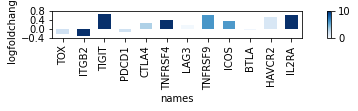

In [177]:
get_bar(CD4,genelist,5,0.5,-0.4,0.8,0.4,'Fig6b_CD4_LOYvsWTY_gene_expr_IC_bar.pdf')

### Fig6c Pathway score comparison

In [4]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [5]:
def Score_comparison(scores,pathways,group,levels,color_palette,box_pairs,n,m,file):
    #Scale Scores
    from sklearn import preprocessing
    scaled_scores = pd.DataFrame(preprocessing.scale(scores.loc[:,pathways]),
                                 index = scores.index,columns = pathways)
    scaled_scores[group] = scores[group].copy()

    #Plotting
    fig,axs = plt.subplots(1,len(pathways),figsize=(n,m))
    plt.subplots_adjust(wspace=0.7)
    from statannot import add_stat_annotation
    for i in range(0,len(pathways)):
        ax = axs[i]
        path = pathways[i]
        sns.barplot(data=scaled_scores, x=group, y=path, saturation=1,
                         order=levels,errorbar='se',capsize=0.05,errwidth=1,
                         palette=color_palette,ax=ax)

        test_results = add_stat_annotation(ax, data=scaled_scores, x=group, y=path,
                                           box_pairs=box_pairs,
                                           test='Mann-Whitney', text_format='full',
                                           line_offset=0,loc='outside',
                                           verbose=0)
        if i==0:
            ax.set_ylabel('Scaled Scores',fontweight='bold')
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(path,fontweight = 'bold',pad=20,fontsize=10)
        labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=10,fontsize=8)
        ax.tick_params(axis='y', pad=-1)
        ax.tick_params(axis='x', pad=-1)
    plt.savefig(file,dpi=300,bbox_inches='tight')

In [ ]:
Score_comparison(CD4.obs,pathways=df_CD4.columns,group='LOY',levels = ['WTY_SCR','LOY_SCR'],
                 color_palette={'LOY_SCR':'#c11c1d','WTY_SCR':'#195697'},
                 box_pairs = [('WTY_SCR','LOY_SCR')],n=7,m=2,
                 file='Fig5f_CD4_bar_LOYvsnoLOY_Pathway_scores.pdf')

# CD8

In [80]:
CD8 = adata[adata.obs['Celltype2']=='CD8+_T_cell',:].copy()
CD8

AnnData object with n_obs × n_vars = 88926 × 14090
    obs: 'SampleID', 'DataID', 'Age', 'Sex', 'Treatment', 'Organ', 'Cancertype', 'tissue_type', 'DataSampleID', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', '_scvi_batch', '_scvi_labels', 'Celltype1', 'Celltype2', 'Celltype3', 'Cancertype_TCGA', 'RL_Prediction_Only9genes', 'LOY', 'Celltype2_LOY_Level', 'Celltype2_LOY'
    var: 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cancertype_colors', 'Celltype1_colors', 'Celltype2_colors', 'DataID_colors', 'Organ_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

### Pathway score calculation

In [83]:
df_CD8 = pd.read_excel('Pathway_genelist_CD8.xlsx')
for column in df_CD8.columns:
    #Get gene list
    marker_Genes = df_CD8[column].dropna().tolist()  
    marker_Genes = set(marker_Genes).intersection(CD8.var_names)
    #Signature calculation
    sc.tl.score_genes(
        CD8,
        marker_Genes,
        ctrl_size=50,
        gene_pool=None,
        n_bins=25,
        score_name=column,  
        random_state=0,
        copy=False,
        use_raw=False
    )
CD8.write_h5ad('scRNAseq_pancan_Male_CD8.h5ad',compression='gzip')

In [5]:
CD8 = sc.read_h5ad('scRNAseq_pancan_Male_CD8.h5ad')

### Fig6d Gene Expr

In [170]:
CD8.layers['scaled'] = sc.pp.scale(CD8,copy=True).X

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


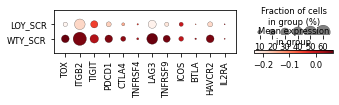

In [171]:
#Fig6d dotplot
sc.pl.dotplot(CD8, genelist, 'LOY', layer='scaled',dendrogram=False,
              figsize = (5,0.8),save='Fig6d_CD8_LOYvsnoLOY_gene_expr_IC_dot.pdf')

           names  logfoldchanges          pvals      pvals_adj    logpadj
names                                                                    
TOX          TOX       -1.146262  1.448765e-182  8.692587e-182  10.000000
ITGB2      ITGB2       -0.573648  3.062549e-146  1.225019e-145  10.000000
TIGIT      TIGIT       -0.195318   3.111901e-19   4.667852e-19  10.000000
PDCD1      PDCD1       -0.844893  9.435190e-113  1.887038e-112  10.000000
CTLA4      CTLA4       -0.918587   9.592772e-54   1.644475e-53  10.000000
TNFRSF4  TNFRSF4       -0.463593   2.702319e-04   2.947985e-04   3.530475
LAG3        LAG3       -0.910380  3.587026e-218  4.304431e-217  10.000000
TNFRSF9  TNFRSF9       -1.090141  4.072641e-135  1.221792e-134  10.000000
ICOS        ICOS       -0.036816   7.100151e-05   9.466868e-05   4.023794
BTLA        BTLA       -0.888694   1.531909e-04   1.838291e-04   3.735586
HAVCR2    HAVCR2       -0.896257  1.313826e-127  3.153182e-127  10.000000
IL2RA      IL2RA        0.008472   5.5

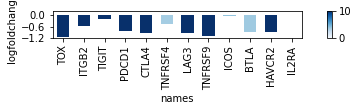

In [178]:
get_bar(CD8,genelist,5,0.5,-1.2,0.2,0.6,'Fig6d_CD8_LOYvsWTY_gene_expr_IC_bar.pdf')

### Fig6e Pathway score comparison

In [ ]:
Score_comparison(CD8.obs,pathways=df_CD8.columns,group='LOY',levels = ['WTY_SCR','LOY_SCR'],
                 color_palette={'LOY_SCR':'#c11c1d','WTY_SCR':'#195697'},
                 box_pairs = [('WTY_SCR','LOY_SCR')],n=7,m=2,
                 file='Fi6e_CD8_bar_LOYvsnoLOY_Pathway_scores.pdf')